<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reformat" data-toc-modified-id="Reformat-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reformat</a></span><ul class="toc-item"><li><span><a href="#NoData-mask" data-toc-modified-id="NoData-mask-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>NoData mask</a></span></li><li><span><a href="#Pixel-index" data-toc-modified-id="Pixel-index-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pixel index</a></span></li><li><span><a href="#Write-output" data-toc-modified-id="Write-output-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Write output</a></span></li></ul></li><li><span><a href="#Plots" data-toc-modified-id="Plots-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Bonus" data-toc-modified-id="Bonus-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bonus</a></span><ul class="toc-item"><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear regression</a></span></li></ul></li><li><span><a href="#Seasons" data-toc-modified-id="Seasons-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Seasons</a></span><ul class="toc-item"><li><span><a href="#seasons" data-toc-modified-id="seasons-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>seasons</a></span></li></ul></li></ul></div>

# Results
## Reformat 
*... our results netCDF(s) to match the input text file structure required by the Florida USGS evapotranspiration model.*

Glob for the result dataset(s) and print the header for one of them:

In [70]:
%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')

f = glob.glob("result/*")
f

['result/blue_albedo_2018.dat', 'result/Albedos_MCD43A1.2018.nc']

Open band one of the result dataset and print the header:

In [72]:
import xarray as xr
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

ds = xr.open_dataset(f[1], group="BRDF_Albedo_Parameters_Band1")
ds

<xarray.Dataset>
Dimensions:           (time: 365, x: 1336, y: 1555)
Coordinates:
    lon               (y, x) float64 ...
  * y                 (y) float64 3.447e+06 3.447e+06 ... 2.728e+06 2.727e+06
  * x                 (x) float64 -8.404e+06 -8.403e+06 ... -7.785e+06
    lat               (y, x) float64 ...
  * time              (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
    month             (time) int64 ...
Data variables:
    blue_sky_albedo   (time, y, x) float64 ...
    black_sky_albedo  (time, y, x) float64 ...
    white_sky_albedo  (time, y, x) float32 ...

### NoData mask
Make an array of booleans that represent masked pixels by reading the first timestep of the input dataset and checking for `np.nan`:

In [16]:
# temporarily open the input dataset that we processed previously
with xr.open_dataset("data/MCD43A1.2018.nc") as tmp_ds:
    
    # select timestep 1 of band 1 of the input dataset
    tmp_array = tmp["BRDF_Albedo_Parameters_Band1"][0].sel(Num_Parameters=0)
    
    # get the inverse of the boolean array of invalid pixels
    mask_array = np.logical_not(np.isnan(tmp_array.data))

mask_array

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Make an `xarray.DataArray` for the mask and add it to the results dataset:

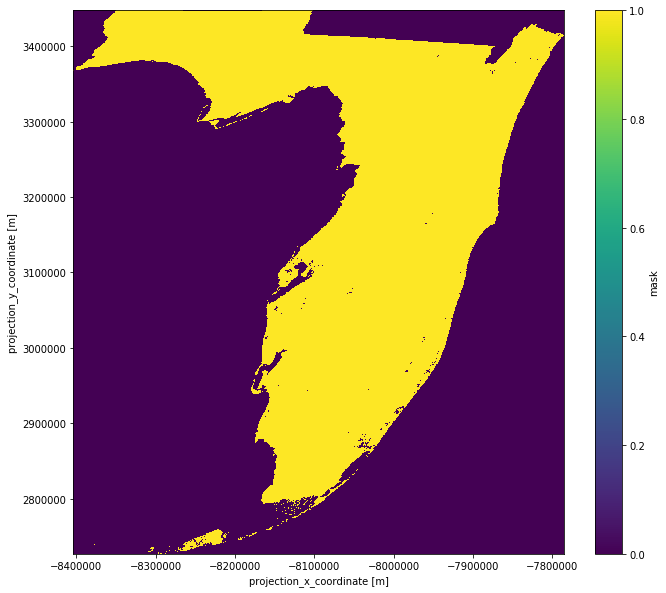

In [23]:
ds.coords["mask"] = xr.DataArray(
    data=mask_array,
    coords=[ds.y, ds.x],
    dims=["y", "x"],
    attrs=dict(
        grid_mapping="crs", 
        flag_values="0 1", 
        flag_meanings="nodata data"))

ds.coords["mask"].plot(x="x", y="y", figsize=(11,10))

There's our mask. Print the header now:

In [24]:
ds

<xarray.Dataset>
Dimensions:           (time: 365, x: 1336, y: 1555)
Coordinates:
    lon               (y, x) float64 ...
  * y                 (y) float64 3.447e+06 3.447e+06 ... 2.728e+06 2.727e+06
  * x                 (x) float64 -8.404e+06 -8.403e+06 ... -7.785e+06
    lat               (y, x) float64 ...
  * time              (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
    month             (time) int64 ...
    mask              (y, x) bool False False False False ... False False False
Data variables:
    blue_sky_albedo   (time, y, x) float64 ...
    black_sky_albedo  (time, y, x) float64 ...
    white_sky_albedo  (time, y, x) float32 ...

### Pixel index

Make an array of index values for the permuted xy arrays. The evapotranspiration model takes inputs that sequence in column-major order:
```
 1  24.249  -79.398  0.000 0.000 0.000 ... 
 2  24.266  -79.398  0.000 0.000 0.000 ...
 3  24.284  -79.398  0.000 0.000 0.000 ...
 4  24.302  -79.398  0.000 0.000 0.000 ...  
```

So, reshape the index array using the shape of longitude array in the results dataset:

In [30]:
xyindex = np.array(list(range(ds.x.size*ds.y.size)))    # seq 1 to npixels
xyindex = xyindex.reshape(ds.lon.shape)                 # reshape with lon

xyindex

array([[      0,       1,       2, ...,    1333,    1334,    1335],
       [   1336,    1337,    1338, ...,    2669,    2670,    2671],
       [   2672,    2673,    2674, ...,    4005,    4006,    4007],
       ...,
       [2073472, 2073473, 2073474, ..., 2074805, 2074806, 2074807],
       [2074808, 2074809, 2074810, ..., 2076141, 2076142, 2076143],
       [2076144, 2076145, 2076146, ..., 2077477, 2077478, 2077479]])

Add `xyindex` array to the dataset as a coordinate variable:

In [31]:
ds.coords["xyindex"] = xr.DataArray(
    data=xyindex,
    coords=[ds.y, ds.x],
    dims=["y", "x"])

ds

<xarray.Dataset>
Dimensions:           (time: 365, x: 1336, y: 1555)
Coordinates:
    lon               (y, x) float64 ...
  * y                 (y) float64 3.447e+06 3.447e+06 ... 2.728e+06 2.727e+06
  * x                 (x) float64 -8.404e+06 -8.403e+06 ... -7.785e+06
    lat               (y, x) float64 ...
  * time              (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
    month             (time) int64 ...
    mask              (y, x) bool False False False False ... False False False
    xyindex           (y, x) int64 0 1 2 3 4 ... 2077476 2077477 2077478 2077479
Data variables:
    blue_sky_albedo   (time, y, x) float64 ...
    black_sky_albedo  (time, y, x) float64 ...
    white_sky_albedo  (time, y, x) float32 ...

### Write output
Now write each valid pixel's time series to an output text file. This could take a while so make a simple progress bar widget to monitor progress:

In [46]:
import time, sys
from IPython.display import clear_output

def update_progress(progress, nbar=20):
    """Simple ASCII progress bar for Jupyter environment."""
    
    if isinstance(progress, int): 
        progress = float(progress)
    if not isinstance(progress, float): 
        progress = 0
    if progress < 0: 
        progress = 0
    if progress >= 1: 
        progress = 1
    block = int(round(nbar*progress))
    
    clear_output(wait = True)
    prog = "Progress: [{0}] {1:.1f}%"
    print(prog.format("#"*block+"-"*(nbar-block), progress*100))

Loop over pixels and write valid data to text file:

In [82]:
npixel = 0          # a counter

# open output table for writing
with open("result/blue_albedo_2018.dat", "w") as f:
    
    # iterate over rows
    for i in range(0, ds.y.size):
        
        # iterate over columns
        for j in range(0, ds.x.size):
        
            # select pixel
            tmp = ds.isel(x=i, y=j)
            
            # if mask value == True (valid data)
            if tmp.coords["mask"]:
                
                # join row items with tabs and write
                f.write("\t".join([
                    str(npixel),
                    str(tmp.lat.data),
                    str(tmp.lon.data),
                    "\t".join([str(v) for v in tmp.data])]) + "\n")
            
            # update progress bar
            update_progress((i * ds.y.size + j) / ds.xyindex.size)

update_progress(1) # done

KeyError: 'mask'

In [ ]:
# open output table for writing
with open("result/blue_albedo_2018.dat", "w") as f:
    
    # iterate over rows
    for i in range(0, test.y.size):
        
        # iterate over columns
        for j in range(0, test.x.size):
        
            update_progress(i/test.xyindex.size)


#update_progress(1)

In [ ]:
#masked = ds["black_sky_albedo"].groupby("xyindex").apply(xr.ufuncs.isnan)
#masked


test = black_sky_albedo.isel(x=slice(0, 100), y=slice(0,100))

test.groupby("xyindex")

## Plots

```python
import cartopy.crs as ccrs

bsamo.plot.pcolormesh(
    'xdim', 
    'ydim', 
    col='month', 
    col_wrap=3, 
    robust=True, 
    figsize=(16,18),
    #transform=ccrs.Sinusoidal(),
    #subplot_kws={'projection': ccrs.Sinusoidal(-82, 28)}
)

ax.set_yticklabels([])
ax.set_xticklabels([])

###########################3

bsa[0].plot.pcolormesh(x='x', y='y', robust=True, figsize=(10, 9),)
wsa[0].plot.pcolormesh(x='x', y='y', robust=True, figsize=(10, 9),)
alb[0].plot.pcolormesh(x='x', y='y', robust=True, figsize=(10, 9),)

```

In [ ]:
import glob
f = glob.glob("result/*"); f

In [ ]:
import xarray as xr
ds = xr.open_dataset(f[0]); ds

In [ ]:
b1 = xr.open_dataset(f[0], group="BRDF_Albedo_Parameters_Band1"); b1

In [ ]:
1/0.001

In [ ]:
for i, b in enumerate([
    "BRDF_Albedo_Parameters_Band1",
    "BRDF_Albedo_Parameters_Band2",
    "BRDF_Albedo_Parameters_Band3",
    "BRDF_Albedo_Parameters_Band4",
    "BRDF_Albedo_Parameters_Band5",
    "BRDF_Albedo_Parameters_Band6",
    "BRDF_Albedo_Parameters_Band7",
    "BRDF_Albedo_Parameters_nir",
    "BRDF_Albedo_Parameters_shortwave",
    "BRDF_Albedo_Parameters_vis",
]):
    mode = "a" if i!=0 else "w" 
    b1 = xr.open_dataset(f[0], group=b)*1000
    b1.to_netcdf("result/fix.nc", mode=mode, group=b)

In [ ]:
b1["blue_sky_albedo"].min()

In [ ]:
import cartopy.crs as ccrs


#bq[0].plot.pcolormesh(x='x', y='y', robust=True, figsize=(10, 9),)
b1["blue_sky_albedo"].attrs["scale_factor"] = None
blue_test = b1["blue_sky_albedo"].groupby("time.month").mean("time")
blue_test

In [ ]:
blue_test.plot.pcolormesh(
    'x', 
    'y', 
    col='month', 
    col_wrap=3, 
    robust=True, 
    figsize=(10,11),
    transform=ccrs.Sinusoidal(),
    subplot_kws={'projection': ccrs.Sinusoidal(-82, 28)})

###########################3

#bsa[0].plot.pcolormesh(x='x', y='y', robust=True, figsize=(10, 9),)
#wsa[0].plot.pcolormesh(x='x', y='y', robust=True, figsize=(10, 9),)
#alb[0].plot.pcolormesh(x='x', y='y', robust=True, figsize=(10, 9),)

In [ ]:
%matplotlib inline
import cartopy.feature as feat
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', **{
    'family': 'normal', 
    'weight': 'normal', 
    'size': 16})

In [ ]:
plt.figure(1, figsize=(15,7))

time = ds["time"]

# ----------------------------------------------------------------------------
# iterate over bands

for b in [
    "BRDF_Albedo_Parameters_Band1",
    "BRDF_Albedo_Parameters_Band2",
    "BRDF_Albedo_Parameters_Band3",
    "BRDF_Albedo_Parameters_Band4",
    "BRDF_Albedo_Parameters_Band5",
    "BRDF_Albedo_Parameters_Band6",
    "BRDF_Albedo_Parameters_Band7",
    "BRDF_Albedo_Parameters_nir",
    "BRDF_Albedo_Parameters_shortwave",
    "BRDF_Albedo_Parameters_vis"]:  
    
    print(b)
    band = xr.open_dataset(f[0], group=b)       # get band
    mean = band.groupby("time.season").mean(    # map mean over albedos
        ["x","y"], keep_attrs=True)
    
    for i, a in enumerate([                     # loop over albedos
        ("black_sky_albedo", "black"),
        ("white_sky_albedo", "lightgray"),
        ("blue_sky_albedo", "blue")]):
        
        albedo = mean[a[0]]                     # get albedo
        plt.subplot(311+i)                      # set subplot
        plt.plot(time, albedo*10000,)           # plot

plt.show()

## Bonus

### Linear regression

In [ ]:
import numpy as np
import xarray as xr
from scipy import stats


def xr_linear(xarr): 
    """Linear regression over xarray.DataArray time dimension."""
    
    # getting shapes
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    
    # create x and y variables
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # regression
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    out = xarr[:2].mean('time')
    
    # first create variable for slope and adjust meta   
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = 'units / day'
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = ("If p < 0.05 then the results from"
                            " 'slope' are significant.")
    xarr_p.values = p.reshape(xarr.shape[1:])
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p

    return(xarr_out)

## Seasons

### seasons
Three-monthly: `['DJF', 'MAM', 'JJA', 'SON']`

In [ ]:
b1 = xr.open_dataset(f[0], group="BRDF_Albedo_Parameters_Band1")
b1

In [ ]:
b1means = b1.groupby("time.season").mean(["x","y"], keep_attrs=True)
b1means["blue_sky_albedo"]

In [ ]:
import xarray.plot as xplt

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,4))

alb = ["black_sky_albedo", "white_sky_albedo", "blue_sky_albedo"] 
b1means.isel(season="DJF")["black_sky_albedo"].plot.line(ax=axes[0])